# Import the required libraries and files

In [1]:
import pandas as pd
import numpy as np
import fasttext
from scipy.stats import uniform
import pickle
from tqdm import tqdm
import re
import os
from prettytable import PrettyTable

# scikit-learn
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Tensorflow
import kerastuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense

# Local Packages
import hats.config
import hats.utility as ut
from hats.data_preprocessing import Preprocessing
import hats.ml_model as ml
from hats.config import CONFIG

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
home_data = pd.read_csv('../dataset/dataset.csv', sep=';')
translate_data = pd.read_csv('../dataset/translations_data.csv', sep=';')
sms_translations_data = pd.read_csv('../dataset/sms_translations.csv', sep=',')

stop_words = []
with open('../dataset/stop_words.txt') as f:
  stop_words = f.readlines()
  stop_words = [word.replace('\n', '') for word in stop_words]

In [4]:
import random
ind = [random.randint(0, home_data.shape[0]) for _ in range(10)]

home_data.iloc[ind]

,commands,label
224,ac chala dae,ac on
44,tani gyser start kar da,geyser on
31,Paani garam karne wala machine start kar do,geyser on
131,television ko on kr do bhai,tv on
25,Switch on the geyser,geyser on
218,tiviya off kara ho,tv off
173,plz trn off the ac,ac off
143,tv off kr do,tv off
179,Air conditioner band ho ja,ac off
220,tv band kar,tv off


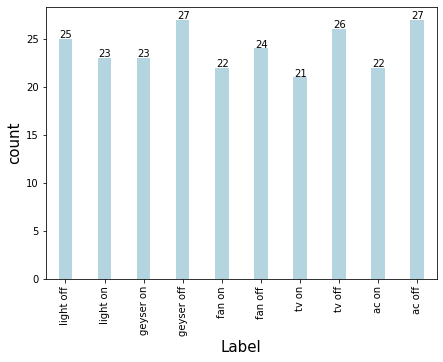

In [5]:
plt.figure(figsize=(7, 5))
ax = sns.countplot('label', data=home_data, color='lightblue')
plt.xlabel('Label', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.xticks(rotation=90)
for p in ax.patches:
    h = np.round(p.get_height(), decimals=2)
    ax.annotate(str(h), (p.get_x() + 0.25, p.get_height() *1.005))
    diff = p.get_width() - 0.35
    p.set_width(0.35)
    p.set_x(p.get_x() + diff * .5)
    
plt.show()

# Fasttext Model Training 

In [6]:
data_preprocess: Preprocessing = Preprocessing(stop_words, sms_translations_data)
home_data_preprocessed = data_preprocess.preprocessing(home_data.copy())
data_preprocess.saveToCsv(home_data_preprocessed)

# Process the output file to remove double quotes ("")
!sed -i 's/"//g' ../output/comm_preprocessed.txt

In [7]:
# Train a fasttext model in supervised fashion
ft_model = ml.createFasttextModel(CONFIG.OUTPUT_DATASET_FILE)

In [8]:
command = data_preprocess.strpreprocessing('mai chahta hu ki tum geyser band kr do')
print(command)
ft_model.predict(command)

mai chahta hu ki tum geyser band


(('__label__geyser_off',), array([0.99661398]))

In [9]:
ft_model.get_sentence_vector('mai chahta hu ki tum geyser band kr do').shape

(150,)

# Create additional columns to preprocessed dataset

## 1. Create <i><b>sent_vec</b></i> column in main dataset for sentence vectors

In [10]:
home_data_vectorized = data_preprocess.convertCommandToVector(home_data_preprocessed, ft_model)
home_data_vectorized.head(5)

,commands,label,sent_vec
0,batti bujha,__label__light_off,"[-0.020573542, 0.03709487, -0.13826478, 0.0545..."
1,balab bujha,__label__light_off,"[-0.035636626, 0.082310684, -0.19299713, 0.083..."
2,balab band,__label__light_off,"[0.0605667, 0.010405923, -0.09599094, -0.01851..."
3,light band,__label__light_off,"[0.05532895, 0.02846798, -0.11641131, 0.004741..."
4,light bujha,__label__light_off,"[-0.040874377, 0.10037273, -0.2134175, 0.10628..."


## 2. Add a column for each class using OVR scheme

After adding the columns, create a single layer perceptron model with 150 inputs and 1 output with sigmoid activation. 

Total number of such models will be equal to the number of classes in the dataset. This is to train multiple models using the OVR technique and while predicting, we will use all the models to predict the final class label of the test command.

In [11]:
home_data_ovr = ut.add_class_ovr_cols(home_data_vectorized.copy())

# Tensorflow Model

In [12]:
# ml.nn_tune_train(data=home_data_ovr, model_names=home_data_ovr['label'].unique())

In [13]:
# Create the models for each class
models = ml.createPerceptronModels(home_data_ovr['label'].unique())

In [14]:
# Compile each model
# for m_name in models.keys():
#     models[m_name]['model'].compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy', ml._f1_score])

models = ml.compileModels(models)

In [15]:
models = ml.nn_modelTrain(data=home_data_ovr, models=models)

Working on model __label__ac_off: 100%|██████████| 10/10 [01:33<00:00,  9.35s/it]   


Saving models to disk...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../output/nn_models/__label__light_off/assets
INFO:tensorflow:Assets written to: ../output/nn_models/__label__light_on/assets
INFO:tensorflow:Assets written to: ../output/nn_models/__label__geyser_on/assets
INFO:tensorflow:Assets written to: ../output/nn_models/__label__geyser_off/assets
INFO:tensorflow:Assets written to: ../output/nn_models/__label__fan_on/assets
INFO:tensorflow:Assets written to: ../output/nn_models/__label__fan_off/assets
INFO:tensorflow:Assets written to: ../output/nn_models/__label__tv_on/assets
INFO:tensorflow:Assets written to: ../output/nn_models/__label__tv_off/assets
INFO:tensorflow:Assets written to: ../output/nn_models/__label__ac_on/assets
INFO:tensorflow:Assets written to: ../output/nn_models/__label__ac_off/assets


#### Plotting the models loss and accuracy

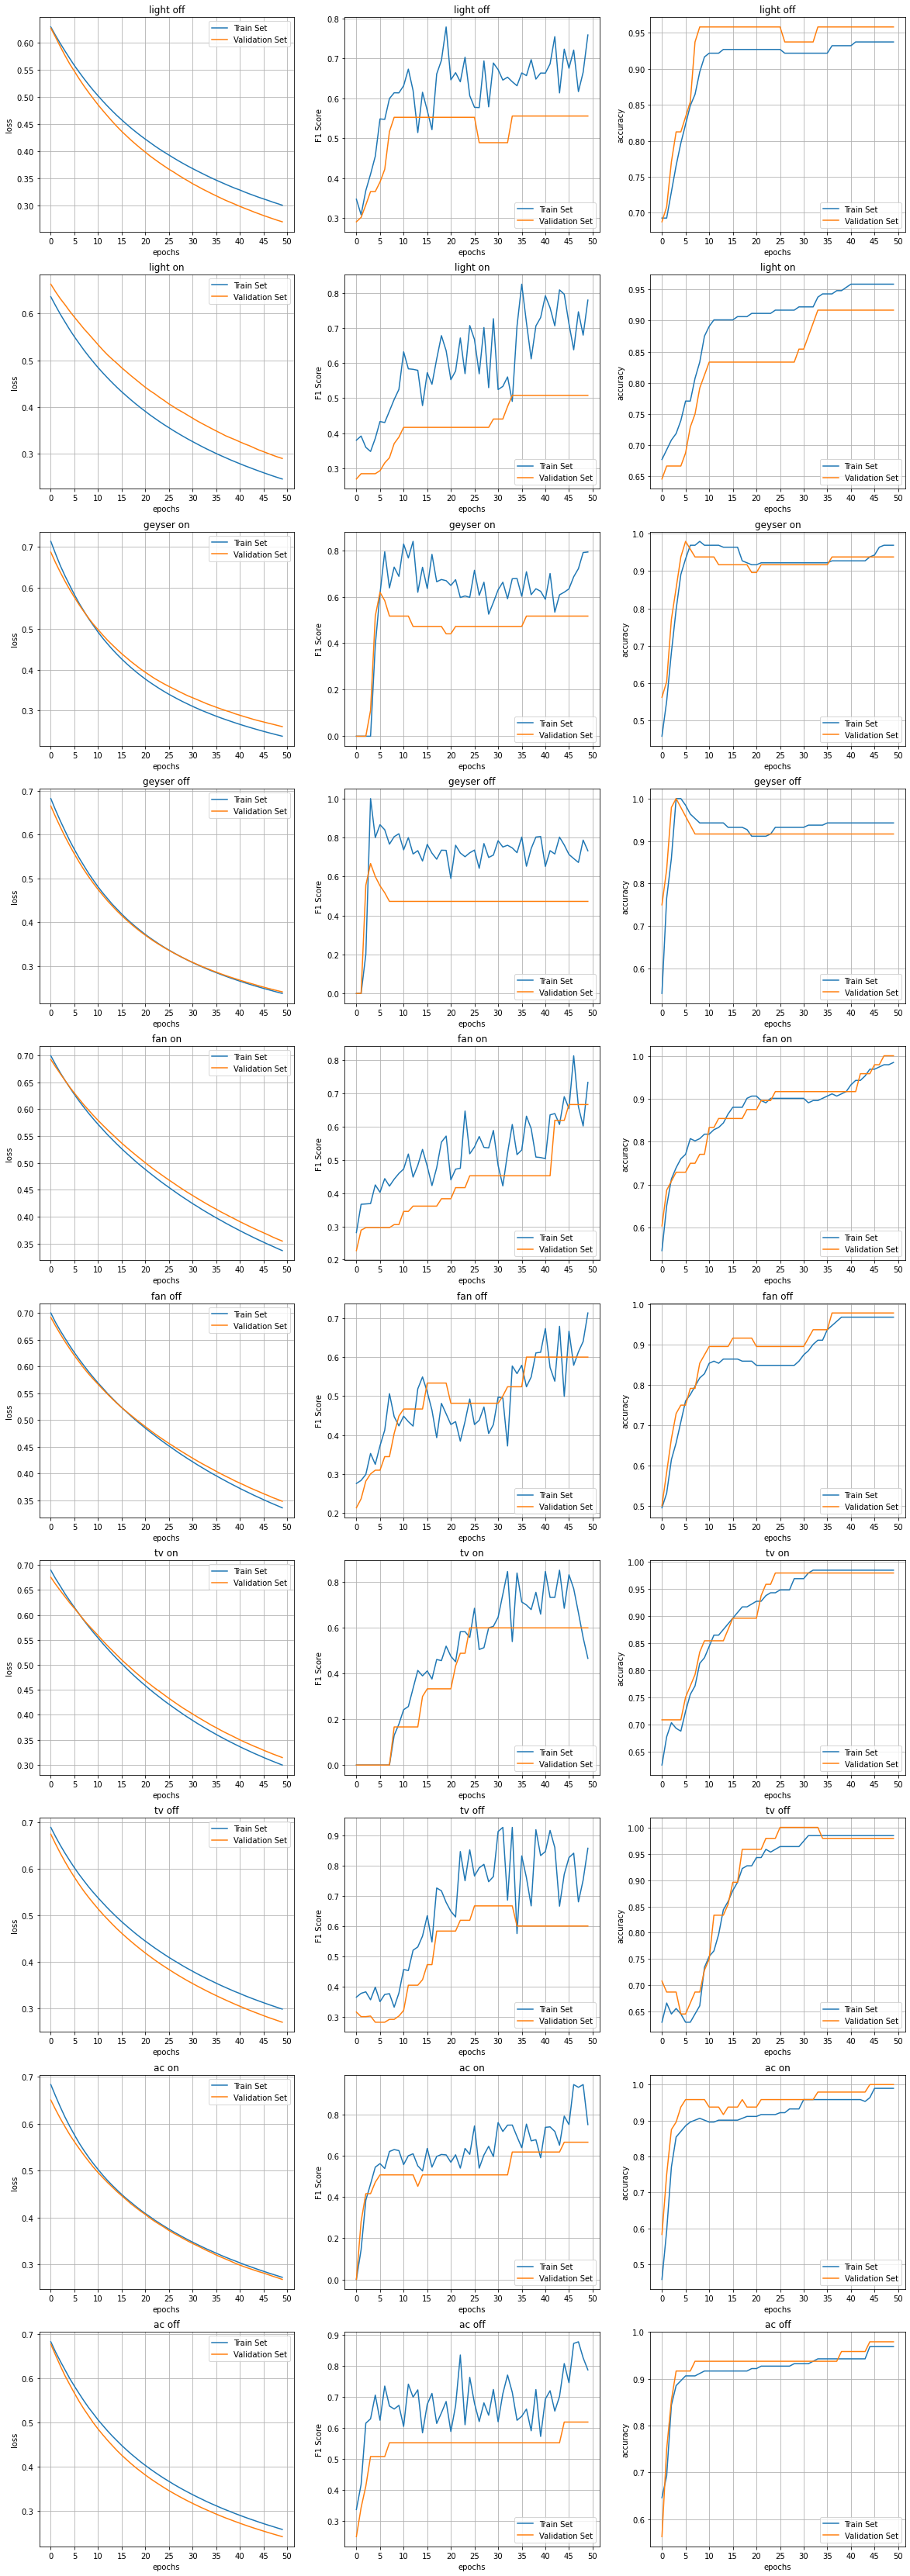

In [20]:
fig = ut.plot(models)

In [19]:
fig.savefig('fig.png', quality=95, bbox_inches='tight', pad_inches=0.5)

In [26]:
ml.print_nn_results(models)

+------------+----------+--------------+--------------+
| Model Name | Val Loss | Val Accuracy | Val F1-Score |
+------------+----------+--------------+--------------+
| light off  |  0.1376  |    91.67%    |    35.56%    |
|  light on  |  0.0675  |   100.00%    |    66.67%    |
| geyser on  |  0.1325  |    97.92%    |    61.90%    |
| geyser off |  0.1166  |    97.92%    |    60.00%    |
|   fan on   |  0.1441  |   100.00%    |    66.67%    |
|  fan off   |  0.1794  |    95.83%    |    55.56%    |
|   tv on    |  0.1206  |    97.92%    |    61.90%    |
|   tv off   |  0.0872  |   100.00%    |    66.67%    |
|   ac on    |  0.1019  |   100.00%    |    66.67%    |
|   ac off   |  0.0919  |   100.00%    |    66.67%    |
+------------+----------+--------------+--------------+


In [27]:
test_command = 'panka on mat kar'

# prediction = ml.nn_modelPredict(test_command, ft_model, data_preprocess, models)
prediction = ml.nn_modelPredict(test_command, ft_model, data_preprocess, model_names=list(models.keys()))

+------------+-----------------------+
| Model Name | Predicted Probability |
+------------+-----------------------+
| light off  |      0.0005274437     |
|  light on  |      0.016004167      |
| geyser on  |      0.0071355086     |
| geyser off |     0.00022251584     |
|   fan on   |       0.67838186      |
|  fan off   |       0.1499096       |
|   tv on    |       0.05975857      |
|   tv off   |     0.00031168674     |
|   ac on    |      0.012784728      |
|   ac off   |     0.00010059685     |
+------------+-----------------------+

Final Prediction:  fan on


# Scikit-learn models

Grid search using SVC

In [44]:
train_df, test_df = ut.data_split(home_data_ovr, test_size=0.3)

In [ ]:
X_train, y_train = train_df['sent_vec'].tolist(), train_df['y']
X_train

In [67]:
classifiers = ml.train(train_df)

Tuning KNeighborsClassifier: 100%|██████████| 3/3 [00:54<00:00, 18.02s/it]

+----------------------+----------------+
|      Model Name      | Train Accuracy |
+----------------------+----------------+
|         SVC          |      1.0       |
|  LogisticRegression  |      1.0       |
| KNeighborsClassifier |      1.0       |
+----------------------+----------------+


In [70]:
results = ml.test(classifiers, test_df)


Model: SVC, Test Accuracy: 1.0

Model: LogisticRegression, Test Accuracy: 0.9583333333333334

Model: KNeighborsClassifier, Test Accuracy: 0.9722222222222222


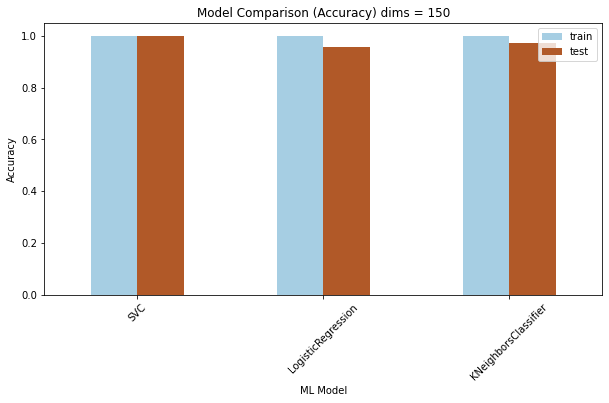

In [71]:
accuracy_scores = {}
for clf_name in classifiers.keys():
    accuracy_scores[clf_name] = np.asarray([classifiers[clf_name]['train_accuracy'], \
        results[clf_name]['test_accuracy']])

accuracy_score_df = pd.DataFrame.from_dict(data=accuracy_scores, orient='index', columns=['train', 'test'])
ax = accuracy_score_df.plot(kind='bar', colormap='Paired', figsize=(10, 5))
plt.xticks(rotation=45)
plt.title(f"Model Comparison (Accuracy) dims = {CONFIG.FT_DIMS}")
plt.xlabel("ML Model")
plt.ylabel("Accuracy")
plt.show()

In [81]:
scores['SVC'].keys()

dict_keys(['fit_time', 'score_time', 'test_precision_macro', 'train_precision_macro', 'test_recall_macro', 'train_recall_macro', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'test_f1_macro', 'train_f1_macro'])

                                             Training Results                                            
+----------------------+--------------------+--------------------+--------------------+--------------------+
|      Model Name      |     Precision      |       Recall       |         F1         |      Accuracy      |
+----------------------+--------------------+--------------------+--------------------+--------------------+
|         SVC          | 0.9964426877470356 | 0.9958947368421052 | 0.9959747854484696 | 0.9958333333333333 |
|  LogisticRegression  | 0.9849705885266526 | 0.9834342105263157 | 0.9834936805890333 | 0.9833333333333332 |
| KNeighborsClassifier |        1.0         |        1.0         |        1.0         |        1.0         |
+----------------------+--------------------+--------------------+--------------------+--------------------+



                                             Testing Results                                             
+---------------------

<AxesSubplot:xlabel='Classifier', ylabel='Train Precision'>

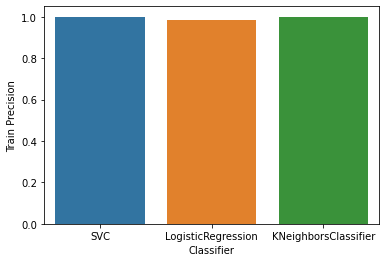

In [104]:
scores = ml.cross_val(classifiers, home_data_ovr, test_df)

train_table = PrettyTable()
train_table.field_names = ['Model Name', 'Precision', 'Recall', 'F1', 'Accuracy']

for name, val in scores.items():
    train_table.add_row([name, np.mean(val['train_precision_macro']), np.mean(val['train_recall_macro']), 
                  np.mean(val['train_f1_macro']), np.mean(val['train_accuracy'])])
print('Training Results'.center(105, ' '))
print(train_table)

test_table = PrettyTable()
test_table.field_names = ['Model Name', 'Precision', 'Recall', 'F1', 'Accuracy']
for name, val in scores.items():
    test_table.add_row([name, np.mean(val['test_precision_macro']), np.mean(val['test_recall_macro']), 
                  np.mean(val['test_f1_macro']), np.mean(val['test_accuracy'])])
print('\n\n')
print('Testing Results'.center(105, ' '))
print(test_table)
    
clf, train_precision, train_recall, train_f1, train_accuracy = [], [], [], [], []
test_precision, test_recall, test_f1, test_accuracy = [], [], [], []
for name, val in scores.items():
    clf.append(name)
    train_precision.append(np.mean(val['train_precision_macro']))
    train_recall.append(np.mean(val['train_recall_macro']))
    train_f1.append(np.mean(val['train_f1_macro']))
    train_accuracy.append(np.mean(val['train_accuracy']))
    
    test_precision.append(np.mean(val['test_precision_macro']))
    test_recall.append(np.mean(val['test_recall_macro']))
    test_f1.append(np.mean(val['test_f1_macro']))
    test_accuracy.append(np.mean(val['test_accuracy']))

score_dict = {'Classifier': clf, 'Train Precision': train_precision, 'Train Recall': train_recall, 
              'Train F1': train_f1, 'Train Accuracy': train_accuracy, 'Test Precision': test_precision, 
              'Test Recall': test_recall, 'Test F1': test_f1, 'Test Accuracy': test_accuracy}
    
score_df = pd.DataFrame.from_dict(score_dict)

# sns.barplot(x='Classifier', y=['Train Precision', 'Train Recall', 'Train F1', 'Train Accuracy'], data=score_df, hue='Classifier')
sns.barplot(x='Classifier', y='Train Precision', data=score_df)


In [105]:
score_df.to_csv('../dataset/scores.csv', index=False)

In [73]:
scores = ml.cross_val(classifiers, train_df, test_df)
scores

{'SVC': {'fit_time': array([0.01681638, 0.00886822, 0.008883  , 0.00914407, 0.01132607]),
  'score_time': array([0.02371073, 0.0141046 , 0.01391673, 0.01364899, 0.01619101]),
  'test_precision_macro': array([1., 1., 1., 1., 1.]),
  'train_precision_macro': array([1., 1., 1., 1., 1.]),
  'test_recall_macro': array([1., 1., 1., 1., 1.]),
  'train_recall_macro': array([1., 1., 1., 1., 1.]),
  'test_roc_auc_ovr': array([1., 1., 1., 1., 1.]),
  'train_roc_auc_ovr': array([1., 1., 1., 1., 1.]),
  'test_f1_macro': array([1., 1., 1., 1., 1.]),
  'train_f1_macro': array([1., 1., 1., 1., 1.])},
 'LogisticRegression': {'fit_time': array([0.00611329, 0.00596356, 0.00594211, 0.00598574, 0.00609183]),
  'score_time': array([0.01311111, 0.0132184 , 0.01301384, 0.01317525, 0.01321602]),
  'test_precision_macro': array([1., 1., 1., 1., 1.]),
  'train_precision_macro': array([0.99285714, 0.99285714, 1.        , 1.        , 0.99285714]),
  'test_recall_macro': array([1., 1., 1., 1., 1.]),
  'train_recall

### Show best estimators for all the models

In [39]:
for clf_name in classifiers:
    print(classifiers[clf_name]['best_estimators'])

SVC(C=0.1, kernel='linear', probability=True, random_state=40)
LogisticRegression(C=0.0001, multi_class='ovr', random_state=40,
                   solver='liblinear')
KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4)


In [40]:
ml.cross_validate(classifiers, X_train, X_test, y_train, y_test)

Accuracy SVC - 1.000 (0.0)
Accuracy LogisticRegression - 0.993 (0.002857142857142861)
Accuracy KNeighborsClassifier - 1.000 (0.0)


In [55]:
test_command = 'gayser on karo ho'
test_command_preprocessed = data_proprocess.strpreprocessing(test_command)
print(f"Test Command: {test_command_preprocessed}")
clf = pickle.load(open(classifiers['SVC']['filename'], 'rb'))
for clf_name in classifiers:
    prediction: str = ml.predict(test_command_preprocessed, ft_model, classifiers[clf_name]['filename'])
    print(f"{clf_name} - predicted '{prediction}'")

Test Command: geyser on karo
SVC - predicted 'Other'
LogisticRegression - predicted 'Other'
KNeighborsClassifier - predicted '__label__geyser_on'


In [46]:
ft_model.get_nearest_neighbors('giser', k=4)
ft_model.predict(test_command)

(('__label__ac_on',), array([0.47008467]))